In [20]:
from __future__ import print_function
import sys
import os
from argparse import ArgumentParser
import cv2 as cv
import time

from openvino.inference_engine import IENetwork, IEPlugin

In [21]:
import numpy as np
import scipy
import PIL.Image
import math
#import caffe
from config_reader import config_reader
import util
import copy
import matplotlib
%matplotlib inline
import pylab as plt

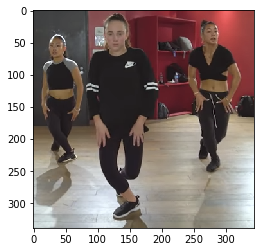

In [22]:
#test_image = '../sample_image/ski.jpg'
#test_image = '../sample_image/upper.jpg'
#test_image = '../sample_image/upper2.jpg'
test_image = '../sample_image/dance.png'
#test_image = '../sample_image/dance_2.png'
#test_image = '../sample_image/dance_3.png'
#test_image = '../sample_image/ballet.jpg'
oriImg = cv.imread(test_image) # B,G,R order
f = plt.imshow(oriImg[:,:,[2,1,0]]) # reorder it before displaying

In [23]:
param, model = config_reader()
multiplier = [x * model['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

In [24]:
model_xml = "/home/yue/Realtime_Multi-Person_Pose_Estimation/model/_trained_COCO/pose_iter_440000.xml"
model_bin = os.path.splitext(model_xml)[0] + ".bin"
prob_threshold = 0.5
labels_map = None

In [25]:
print("Initializing plugin for CPU device...")
plugin = IEPlugin(device="CPU", plugin_dirs=None)

Initializing plugin for CPU device...


In [26]:
print("Adding CPU extenstions...")
plugin.add_cpu_extension("/opt/intel/computer_vision_sdk/deployment_tools/inference_engine/lib/ubuntu_16.04/intel64/libcpu_extension_sse4.so")

Adding CPU extenstions...


In [27]:
print("Reading IR...")
net = IENetwork.from_ir(model=model_xml, weights=model_bin)
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))

Reading IR...


In [28]:
print("Loading IR to the plugin...")
exec_net = plugin.load(network=net, num_requests=2)
# Read and pre-process input image
n, c, h, w = net.inputs[input_blob]

Loading IR to the plugin...


In [29]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

#imageToTest = cv.resize(oriImg, (0,0), fx=1, fy=1, interpolation=cv.INTER_CUBIC)
#imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model['stride'], model['padValue'])
#print (imageToTest_padded.shape)

image = cv.resize(oriImg, (w, h))

image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
image = image.reshape((n, c, h, w))/256 - 0.5
#image = image.reshape((n, c, h, w))
#net.forward() # dry run
#image.reshape(*(1, 3, imageToTest_padded.shape[0], imageToTest_padded.shape[1]))
#image = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))

start_time = time.time()
res = exec_net.infer(inputs={input_blob: image})
print('The CNN took %.2f ms.' % ( 1000 * (time.time() - start_time)))
res_heatMap = res['Mconv7_stage6_L2'];
res_paf = res['Mconv7_stage6_L1']
res_heatMap = np.squeeze(res_heatMap, axis=0)
res_paf = np.squeeze(res_paf, axis=0)


# extract outputs, resize, and remove padding
heatmap = np.transpose(res_heatMap, (1,2,0)) # output 1 is heatmaps

heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)

paf = np.transpose(res_paf, (1,2,0)) # output 0 is PAFs

paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)

heatmap_avg = heatmap_avg + heatmap 
paf_avg = paf_avg + paf 



The CNN took 1053.17 ms.


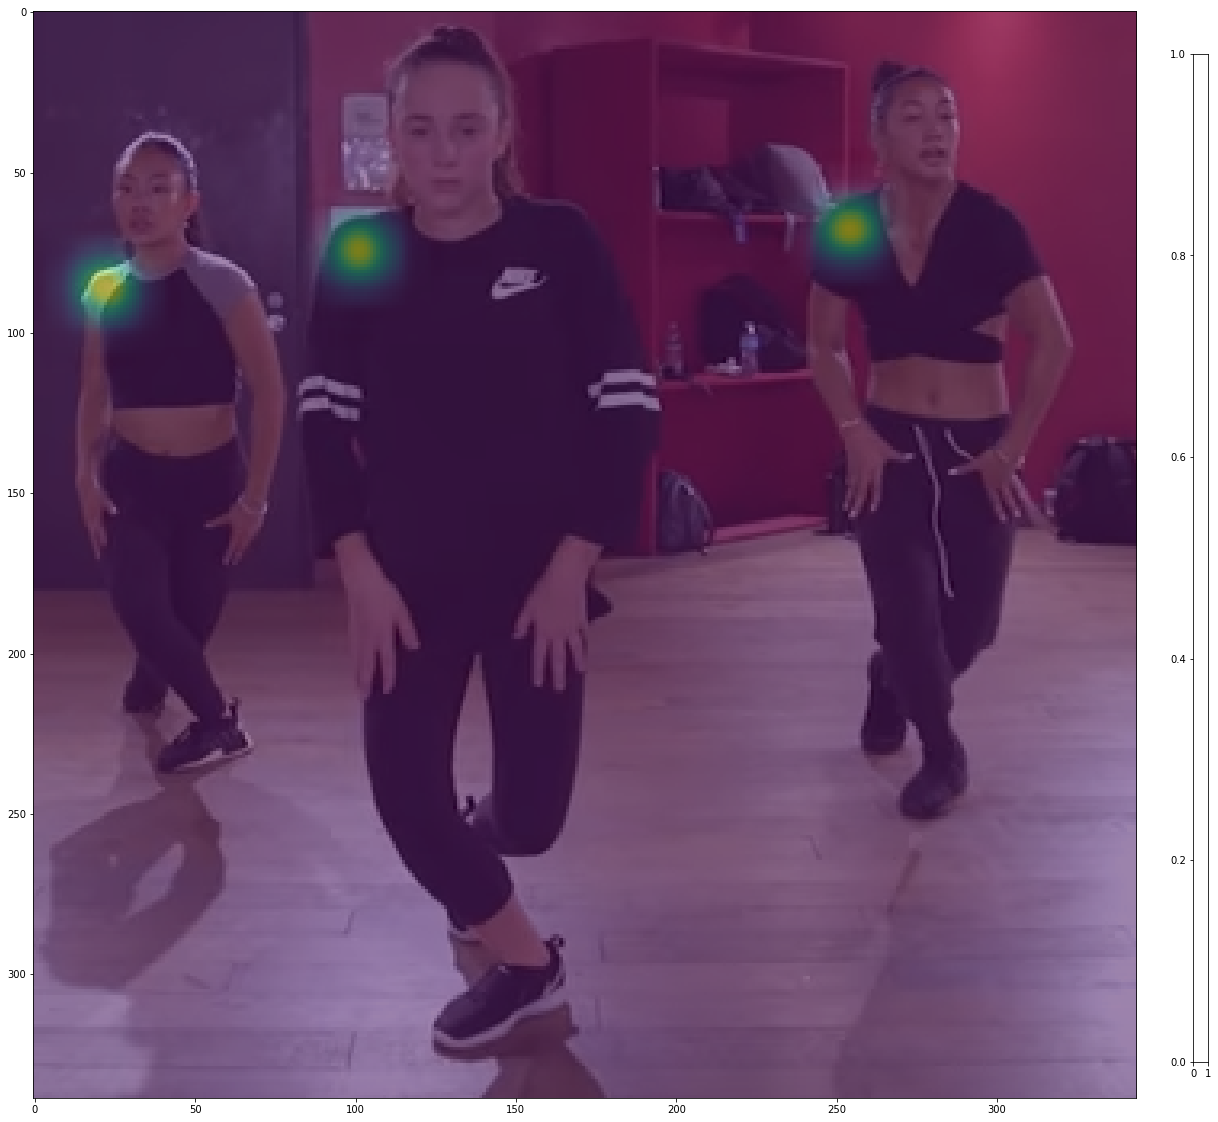

In [30]:
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,2], alpha=.5)
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])


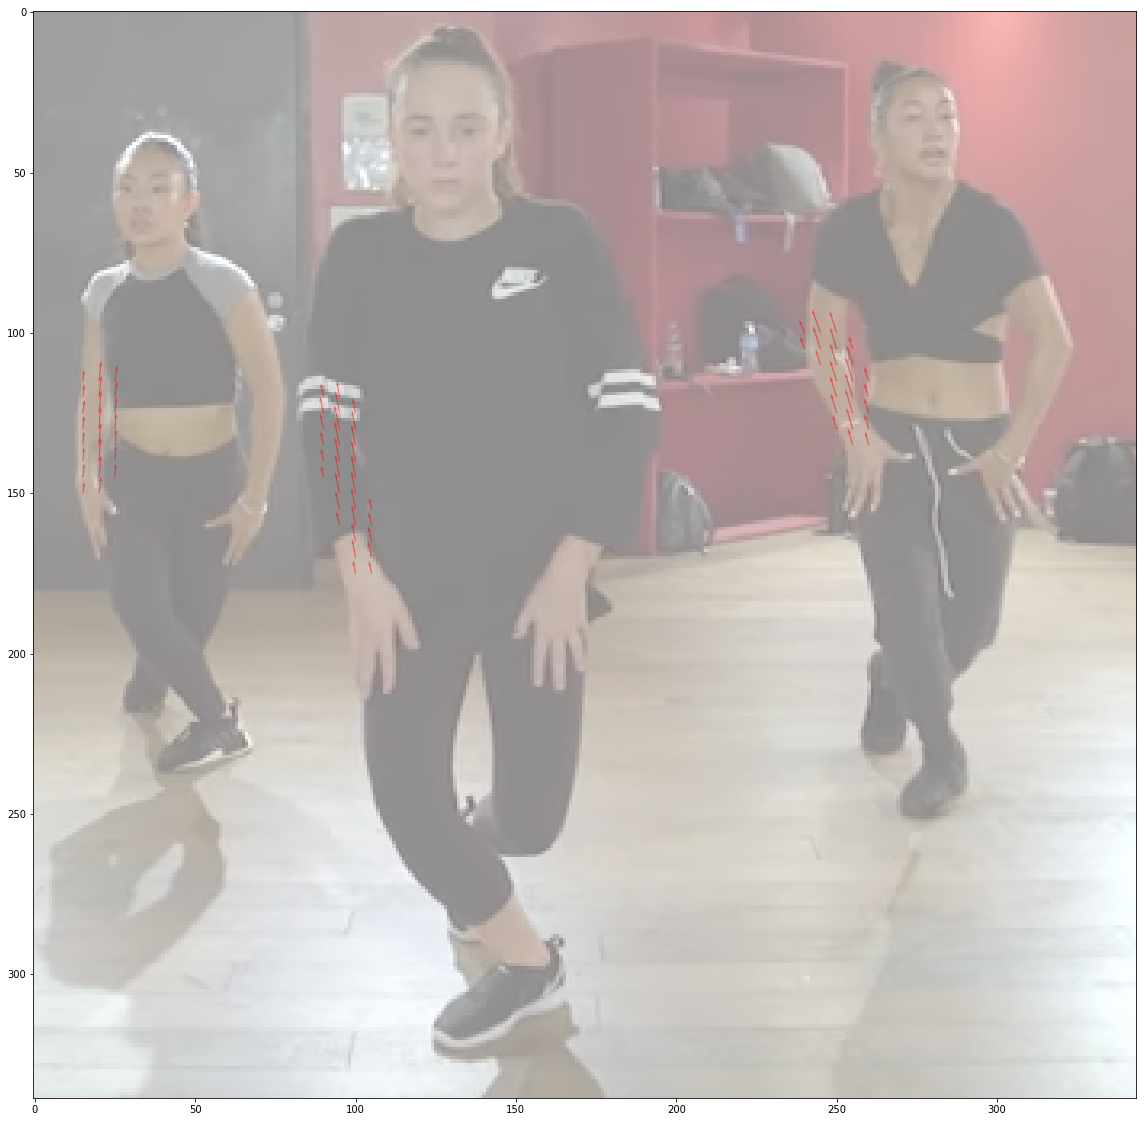

In [31]:
from numpy import ma
U = paf_avg[:,:,16] * -1
V = paf_avg[:,:,17]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

In [32]:
import scipy
print (heatmap_avg.shape)

#plt.imshow(heatmap_avg[:,:,2])
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    x_list = []
    y_list = []
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

(339, 344, 19)


In [33]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [34]:
connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])
                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [35]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [36]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

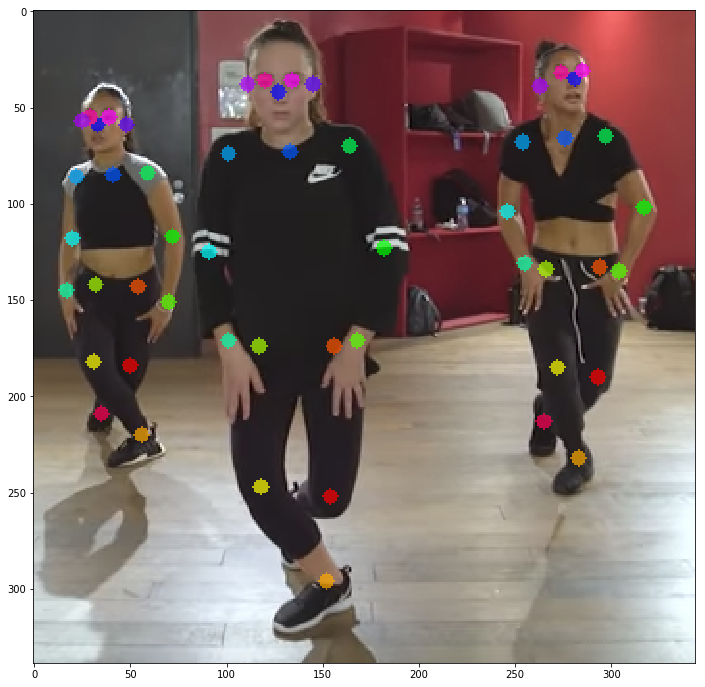

In [37]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

(339, 344, 3)


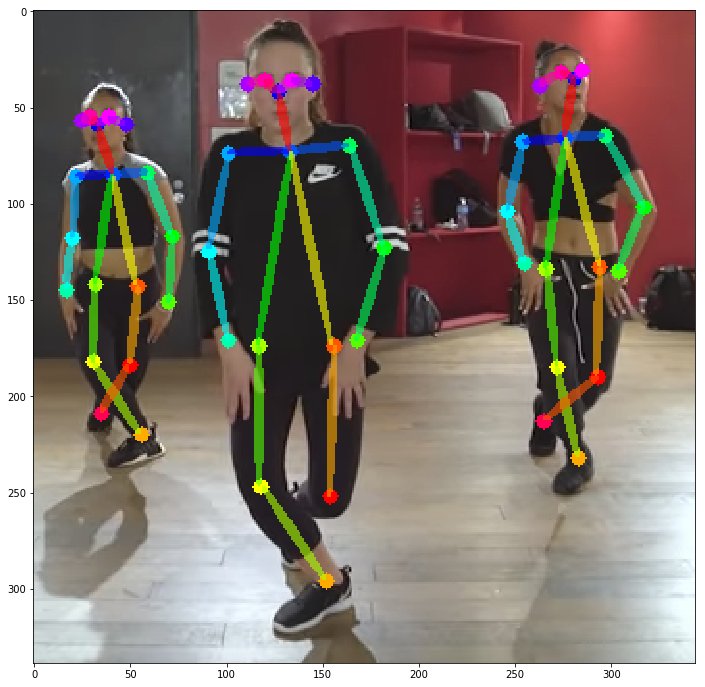

In [38]:
# visualize 2
stickwidth = 2

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
print(canvas[:,:,[2,1,0]].shape)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)